#TP05 - Sentiment Analysis with BERT - Pytorch 🤖
Hans Burkli

In [ ]:
!pip install -q -U watermark
!pip install -qq transformers
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

numpy       : 1.26.4
pandas      : 2.1.4
torch       : 2.4.0+cu121
transformers: 4.42.4



In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
#@title Setup & Config
# Configuración de entorno de Jupyter Notebook
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Importación de librerías estándar
import numpy as np
import pandas as pd
from collections import defaultdict
from textwrap import wrap

# Configuración de gráficos
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
from matplotlib import rc

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

# Importación de librerías de PyTorch
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Configuración de dispositivo para PyTorch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Importación de librerías de Transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

# Importación de herramientas de Scikit-Learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Configuración de semillas para reproducibilidad
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Verificación de dispositivo
print(f"Usando el dispositivo: {device}")


Usando el dispositivo: cuda:0


## Data Example

https://github.com/charlesmalafosse/open-dataset-for-sentiment-analysis


# Descargamos la data

**Sobre la data** : es una base de datos de tweets recopilados con el API de Twitter entre mayo y septiembre de 2018 sobre la worldcup. El sentimiento de los tweets se generó con la API de AWS Comprehend. Para los tweets en español y francés, se tradujeron primero al inglés con Google Translate antes de ser analizados con AWS Comprehend. El sentimiento se clasifica en positivo, negativo, neutral o mixto.

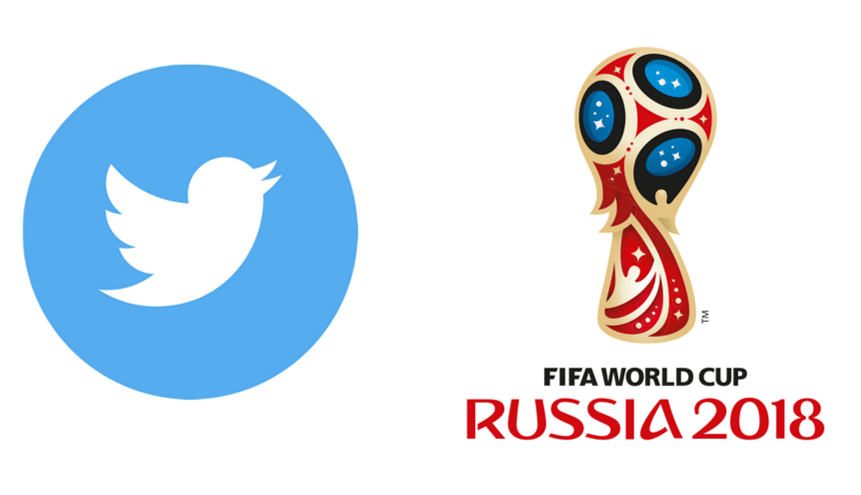

In [ ]:
#@title Descargar data
import pandas as pd
import zipfile
import io
import requests

# URL de las partes del archivo ZIP en GitHub
urls = [
    'https://github.com/charlesmalafosse/open-dataset-for-sentiment-analysis/raw/master/betsentiment-ES-tweets-sentiment-worldcup-split.zip.001',
    'https://github.com/charlesmalafosse/open-dataset-for-sentiment-analysis/raw/master/betsentiment-ES-tweets-sentiment-worldcup-split.zip.002',
    'https://github.com/charlesmalafosse/open-dataset-for-sentiment-analysis/raw/master/betsentiment-ES-tweets-sentiment-worldcup-split.zip.003',
    'https://github.com/charlesmalafosse/open-dataset-for-sentiment-analysis/raw/master/betsentiment-ES-tweets-sentiment-worldcup-split.zip.004',
    'https://github.com/charlesmalafosse/open-dataset-for-sentiment-analysis/raw/master/betsentiment-ES-tweets-sentiment-worldcup-split.zip.005',
    'https://github.com/charlesmalafosse/open-dataset-for-sentiment-analysis/raw/master/betsentiment-ES-tweets-sentiment-worldcup-split.zip.006'
]

# Descargar y combinar las partes
with open('combined_file.zip', 'wb') as combined_file:
    for url in urls:
        response = requests.get(url)
        combined_file.write(response.content)

# Descomprimir el archivo combinado
with zipfile.ZipFile('combined_file.zip', 'r') as z:
    file_names = z.namelist()
    with z.open(file_names[0]) as f:
        try:
            df = pd.read_csv(f, encoding='utf-8')
        except UnicodeDecodeError:
            f.seek(0)  # Reset file pointer
            df2 = pd.read_csv(f, encoding='ISO-8859-1')  # Alternativa común

# Mostrar las primeras filas del DataFrame
df2.head()

# Verificar el contenido del DataFrame
df2.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1072461 entries, 0 to 1072460
Data columns (total 6 columns):
 #   Column              Non-Null Count    Dtype 
---  ------              --------------    ----- 
 0   tweet_date_created  1072461 non-null  object
 1   tweet_id            1072461 non-null  int64 
 2   tweet_text          1072460 non-null  object
 3   language            1072461 non-null  object
 4   sentiment           1072461 non-null  object
 5   sentiment_score     1072461 non-null  object
dtypes: int64(1), object(5)
memory usage: 49.1+ MB


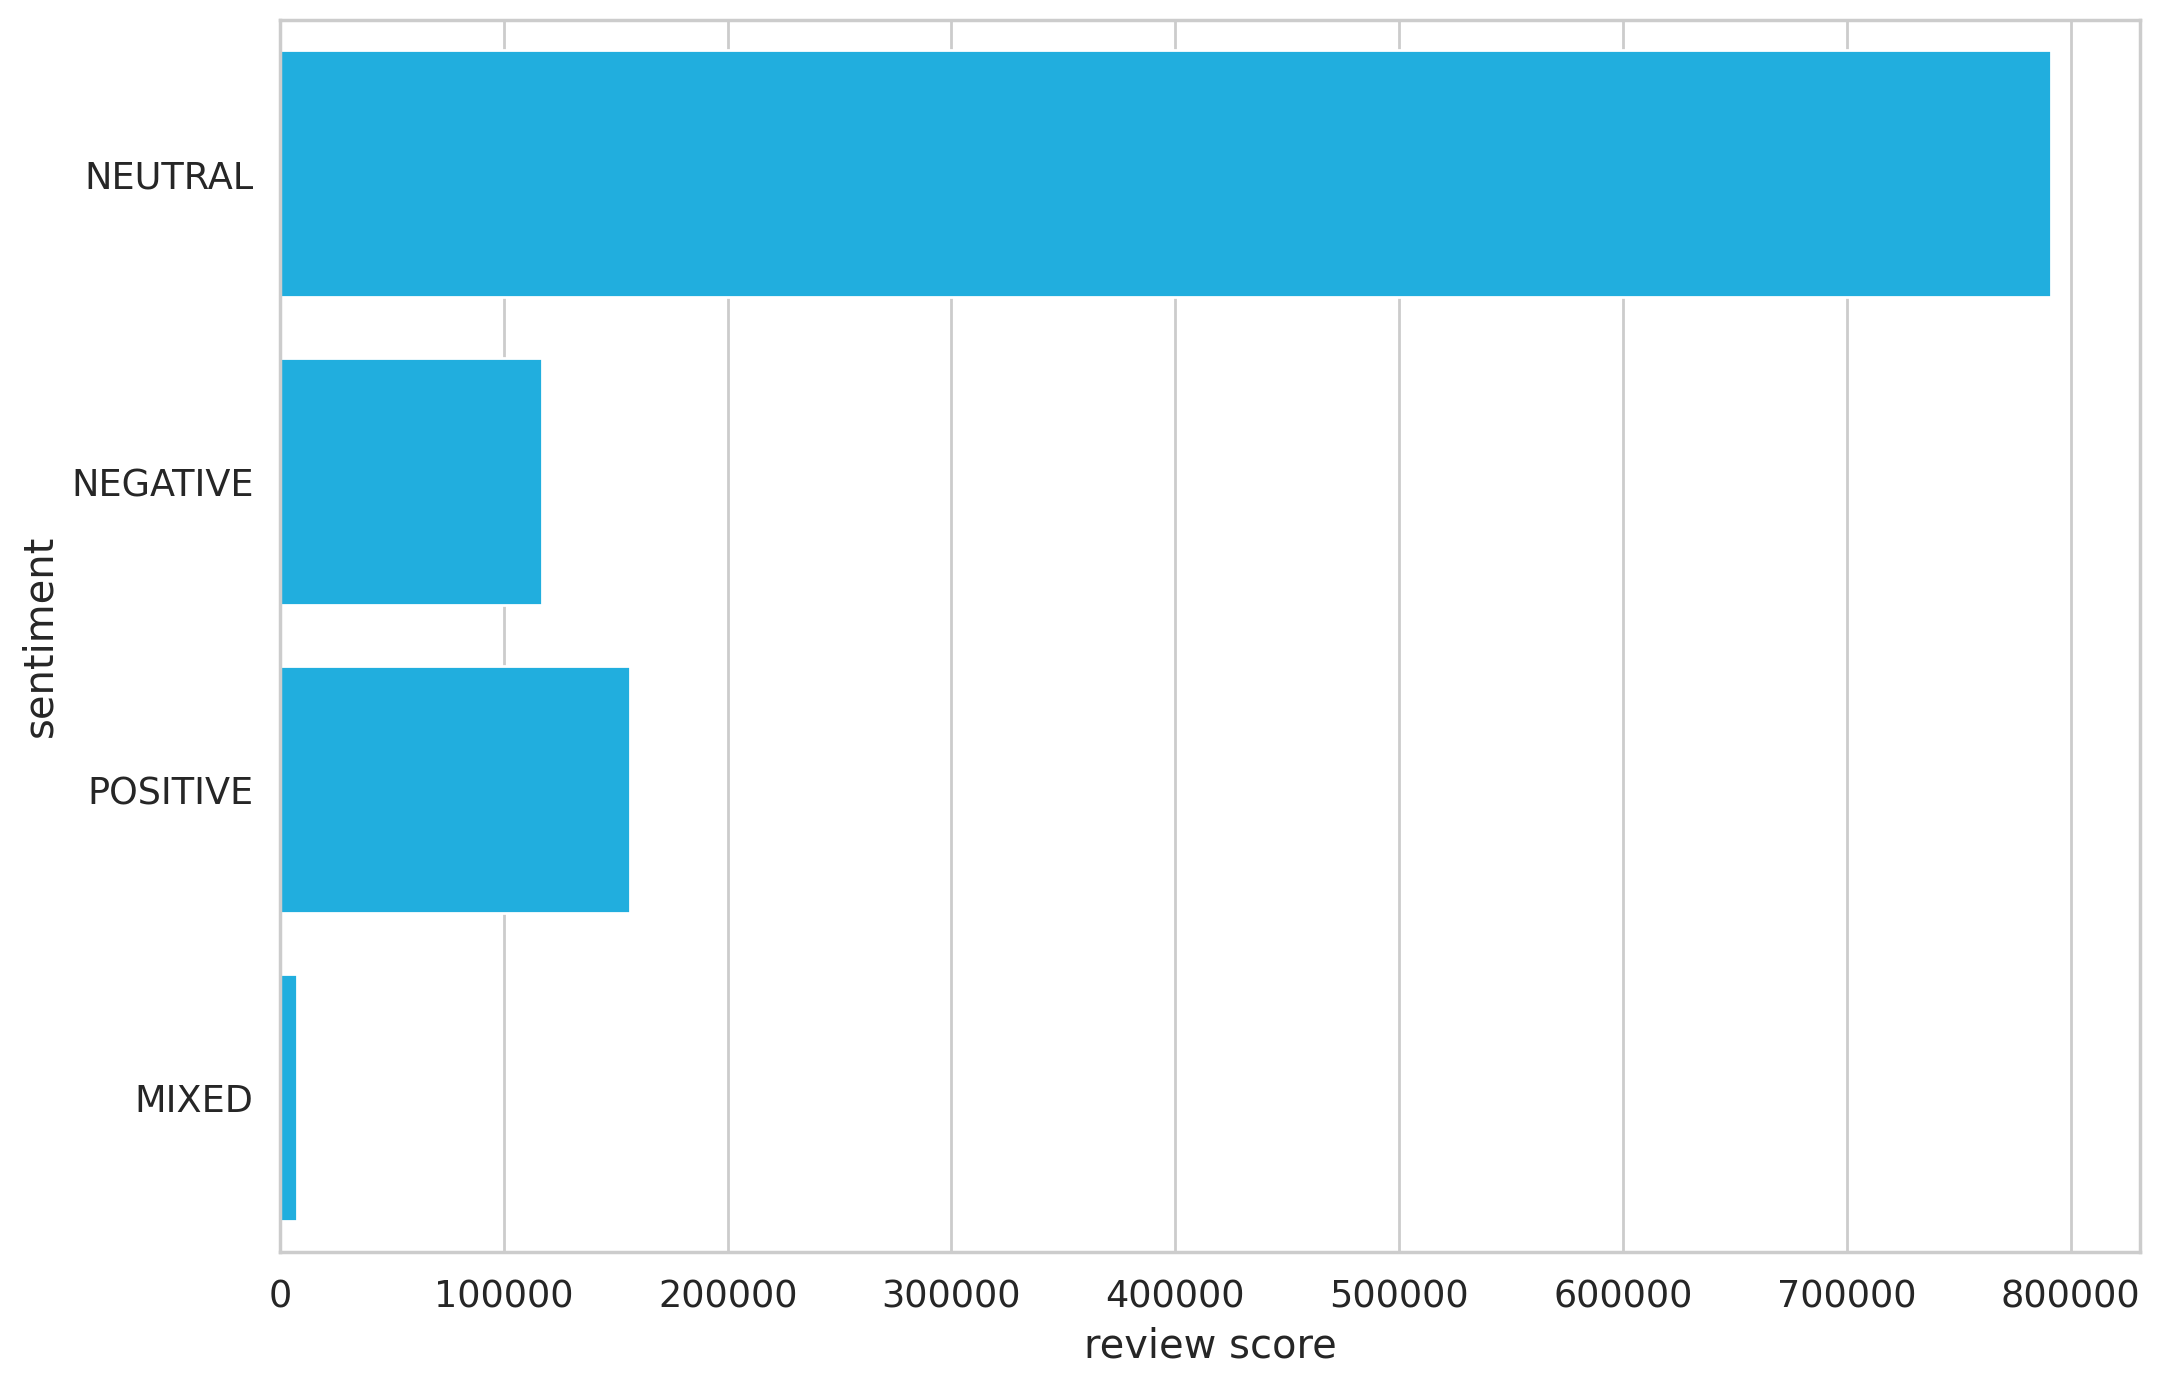

In [ ]:
#@title Distribución según la categoria sentiment
sns.countplot(df2.sentiment)
plt.xlabel('review score');

## Preparación de los datos.

Limpiamos los valores perdidos de la variable *tweet_text*

In [ ]:
# Eliminar filas con valores NaN en la columna 'tweet_text'
df3 = df2.dropna(subset=['tweet_text'])

# Verificar la cantidad de valores NaN en la columna 'tweet_text'
nan_count = df3['tweet_text'].isna().sum()
print(f"Cantidad de valores NaN en 'tweet_text': {nan_count}")

df3.info()

Cantidad de valores NaN en 'tweet_text': 0
<class 'pandas.core.frame.DataFrame'>
Index: 1072460 entries, 0 to 1072460
Data columns (total 6 columns):
 #   Column              Non-Null Count    Dtype 
---  ------              --------------    ----- 
 0   tweet_date_created  1072460 non-null  object
 1   tweet_id            1072460 non-null  int64 
 2   tweet_text          1072460 non-null  object
 3   language            1072460 non-null  object
 4   sentiment           1072460 non-null  object
 5   sentiment_score     1072460 non-null  object
dtypes: int64(1), object(5)
memory usage: 57.3+ MB


Creamos una base de datos con la misma cantidad de casos para cada categoria de *tweet_text*

In [ ]:
# Definir la cantidad deseada de casos por categoría
cases_per_category = 100

# Crear una lista para almacenar los subconjuntos de cada categoría
subsets = []

# Iterar sobre cada categoría y seleccionar la cantidad deseada de casos
for category in ['NEUTRAL', 'NEGATIVE', 'POSITIVE']:
    # Filtrar el DataFrame por la categoría
    subset = df3[df3['sentiment'] == category]

    # Si hay más casos que la cantidad deseada, tomar una muestra aleatoria
    if len(subset) > cases_per_category:
        subset = subset.sample(n=cases_per_category, random_state=1)
    # Si hay menos casos que la cantidad deseada, usar todos los disponibles
    else:
        print(f"Advertencia: La categoría {category} tiene menos de {cases_per_category} casos.")

    # Añadir el subconjunto a la lista
    subsets.append(subset)

# Concatenar todos los subconjuntos en un nuevo DataFrame
df4 = pd.concat(subsets)

# Resetear el índice del DataFrame resultante
df4.reset_index(drop=True, inplace=True)
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_date_created  300 non-null    object
 1   tweet_id            300 non-null    int64 
 2   tweet_text          300 non-null    object
 3   language            300 non-null    object
 4   sentiment           300 non-null    object
 5   sentiment_score     300 non-null    object
dtypes: int64(1), object(5)
memory usage: 14.2+ KB


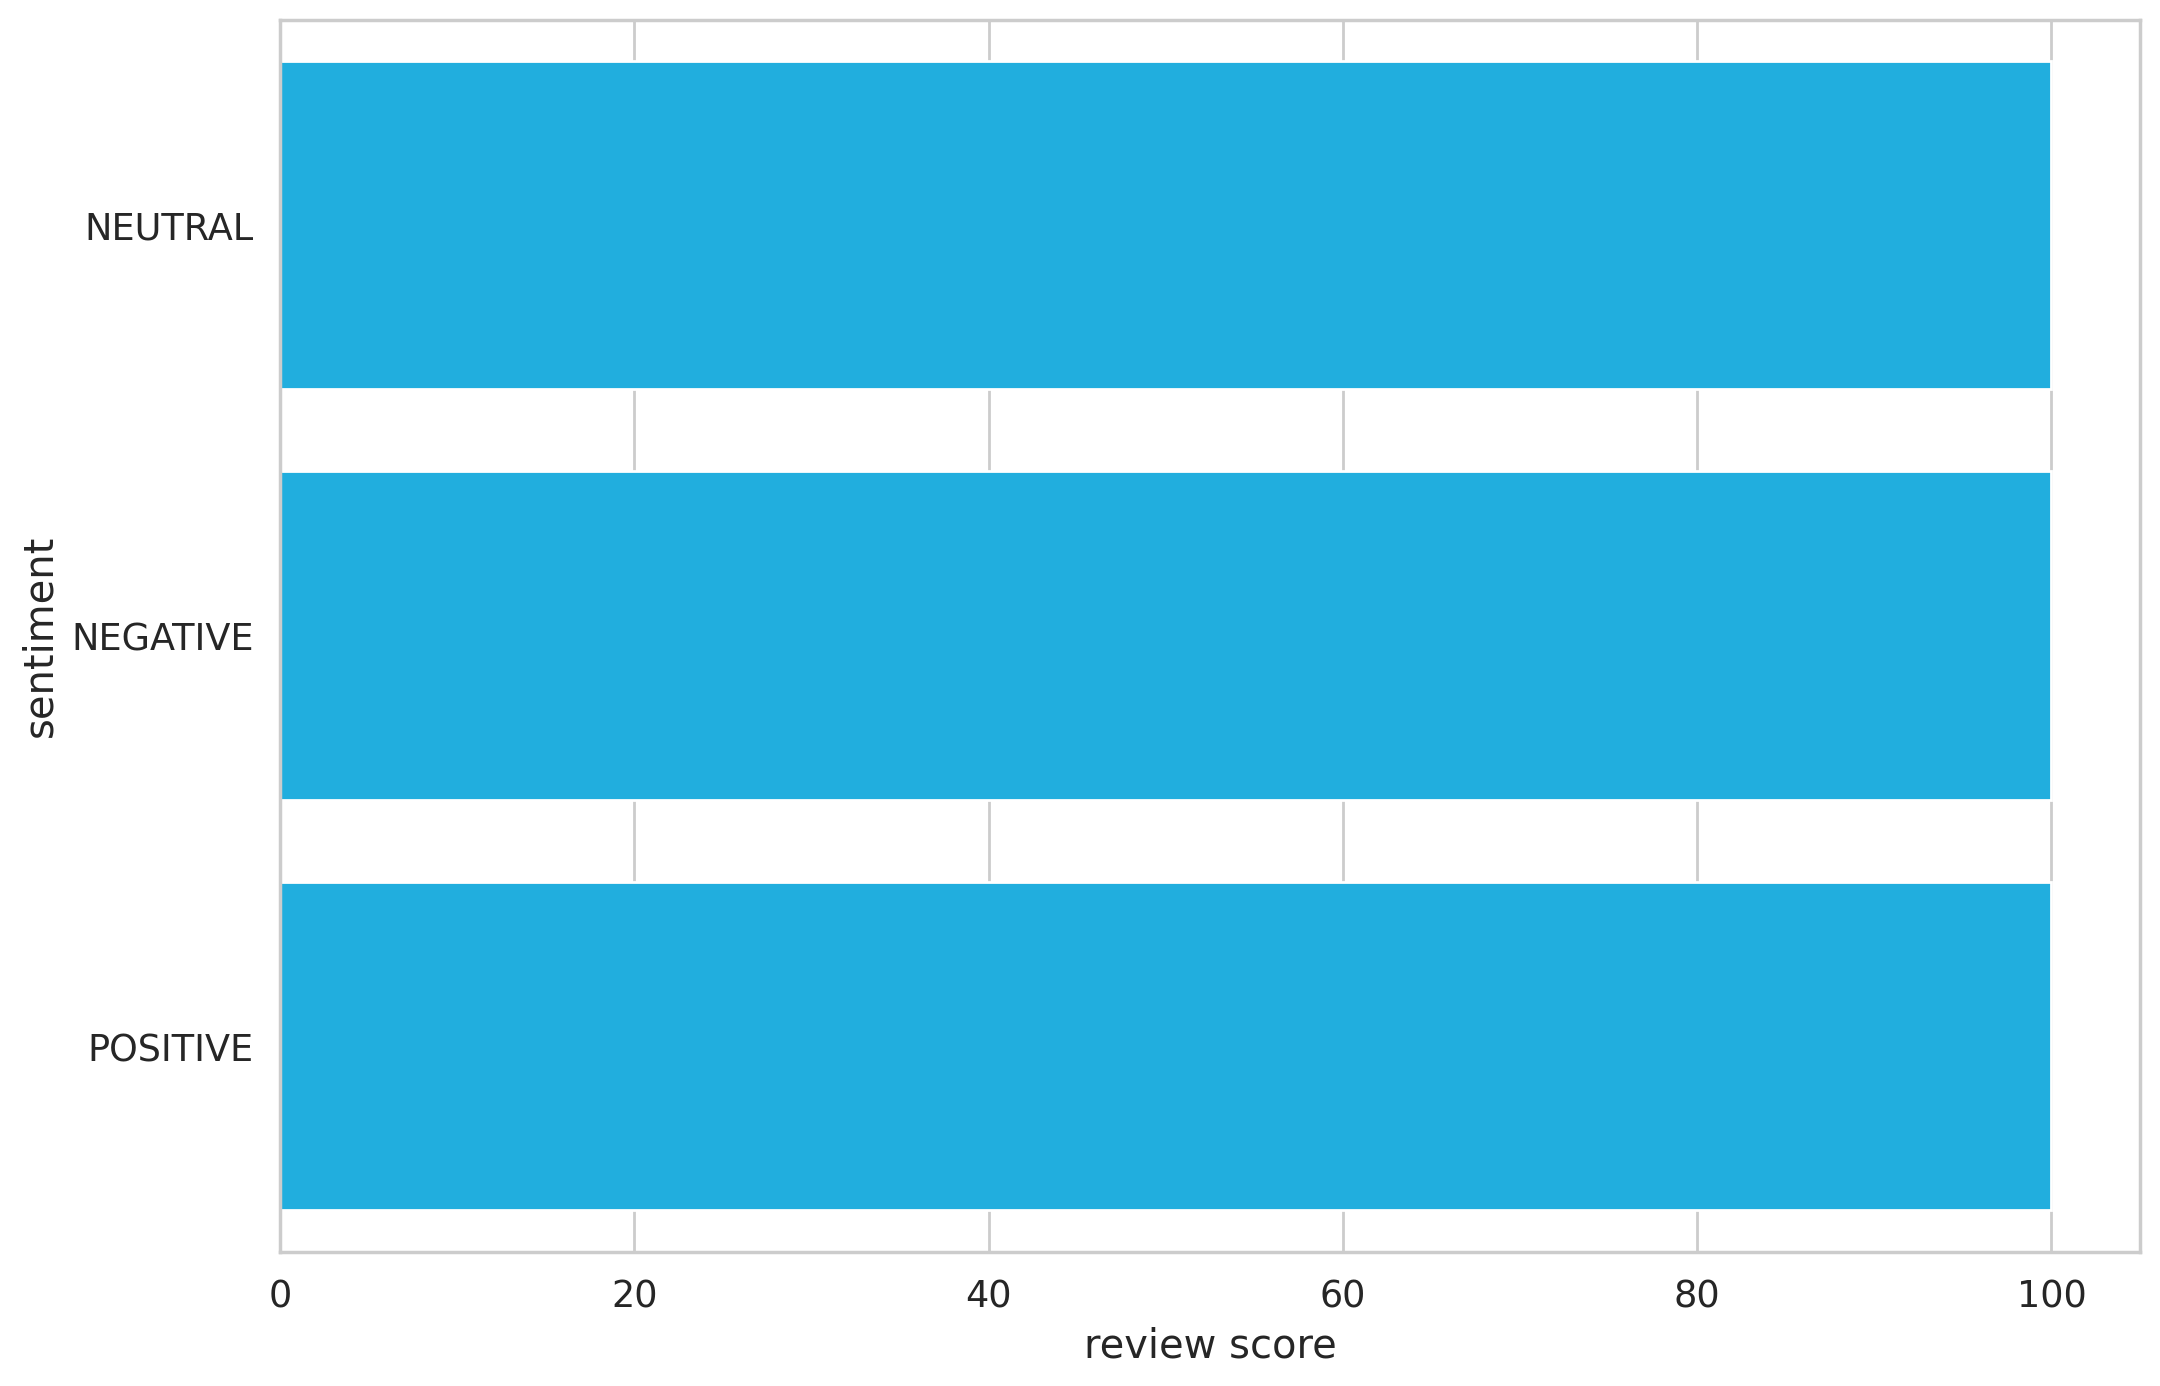

In [ ]:
sns.countplot(df4.sentiment)
plt.xlabel('review score');

Transformamos las etiquetas de sentimiento (sentiment) a valores numéricos (sentimente_num)

In [ ]:
# Diccionario para convertir las etiquetas de sentimiento a valores numéricos
sentiment_to_num = {'NEUTRAL': 1, 'NEGATIVE': 0, 'POSITIVE': 2}

# Crear una nueva columna 'sentiment2' en df3 que contiene los valores numéricos
df4['sentiment_num'] = df4['sentiment'].map(sentiment_to_num)

# Verificar si hay valores NaN después de la conversión
if df4['sentiment_num'].isnull().any():
    raise ValueError("Some sentiments could not be converted to numeric values. Check the mapping and data.")

# Mostrar el DataFrame df4 actualizado
df4.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_date_created  300 non-null    object
 1   tweet_id            300 non-null    int64 
 2   tweet_text          300 non-null    object
 3   language            300 non-null    object
 4   sentiment           300 non-null    object
 5   sentiment_score     300 non-null    object
 6   sentiment_num       300 non-null    int64 
dtypes: int64(2), object(5)
memory usage: 16.5+ KB


# Procesamiento

Se establece el nombre del modelo preentrenado que se utilizará. En este caso, se está utilizando el modelo BERT y el tokenizador correspondiente que se encarga de convertir el texto en tokens que el modelo pueda procesar.

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Se itera sobre cada texto en la columna tweet_text del DataFrame para tokenizar el texto, y se calcula la longitud en tokens de cada texto. La longitud de cada token se almacena en la lista token_lens.

Se genera un histograma que muestra la distribución de las longitudes en tokens. El gráfico ilustra la frecuencia de cada rango de longitud de tokens, con el eje x representando el número de tokens y el eje y la frecuencia de aparición

Promedio de longitud de tokens: 58.01
Máximo de longitud de tokens: 159.00


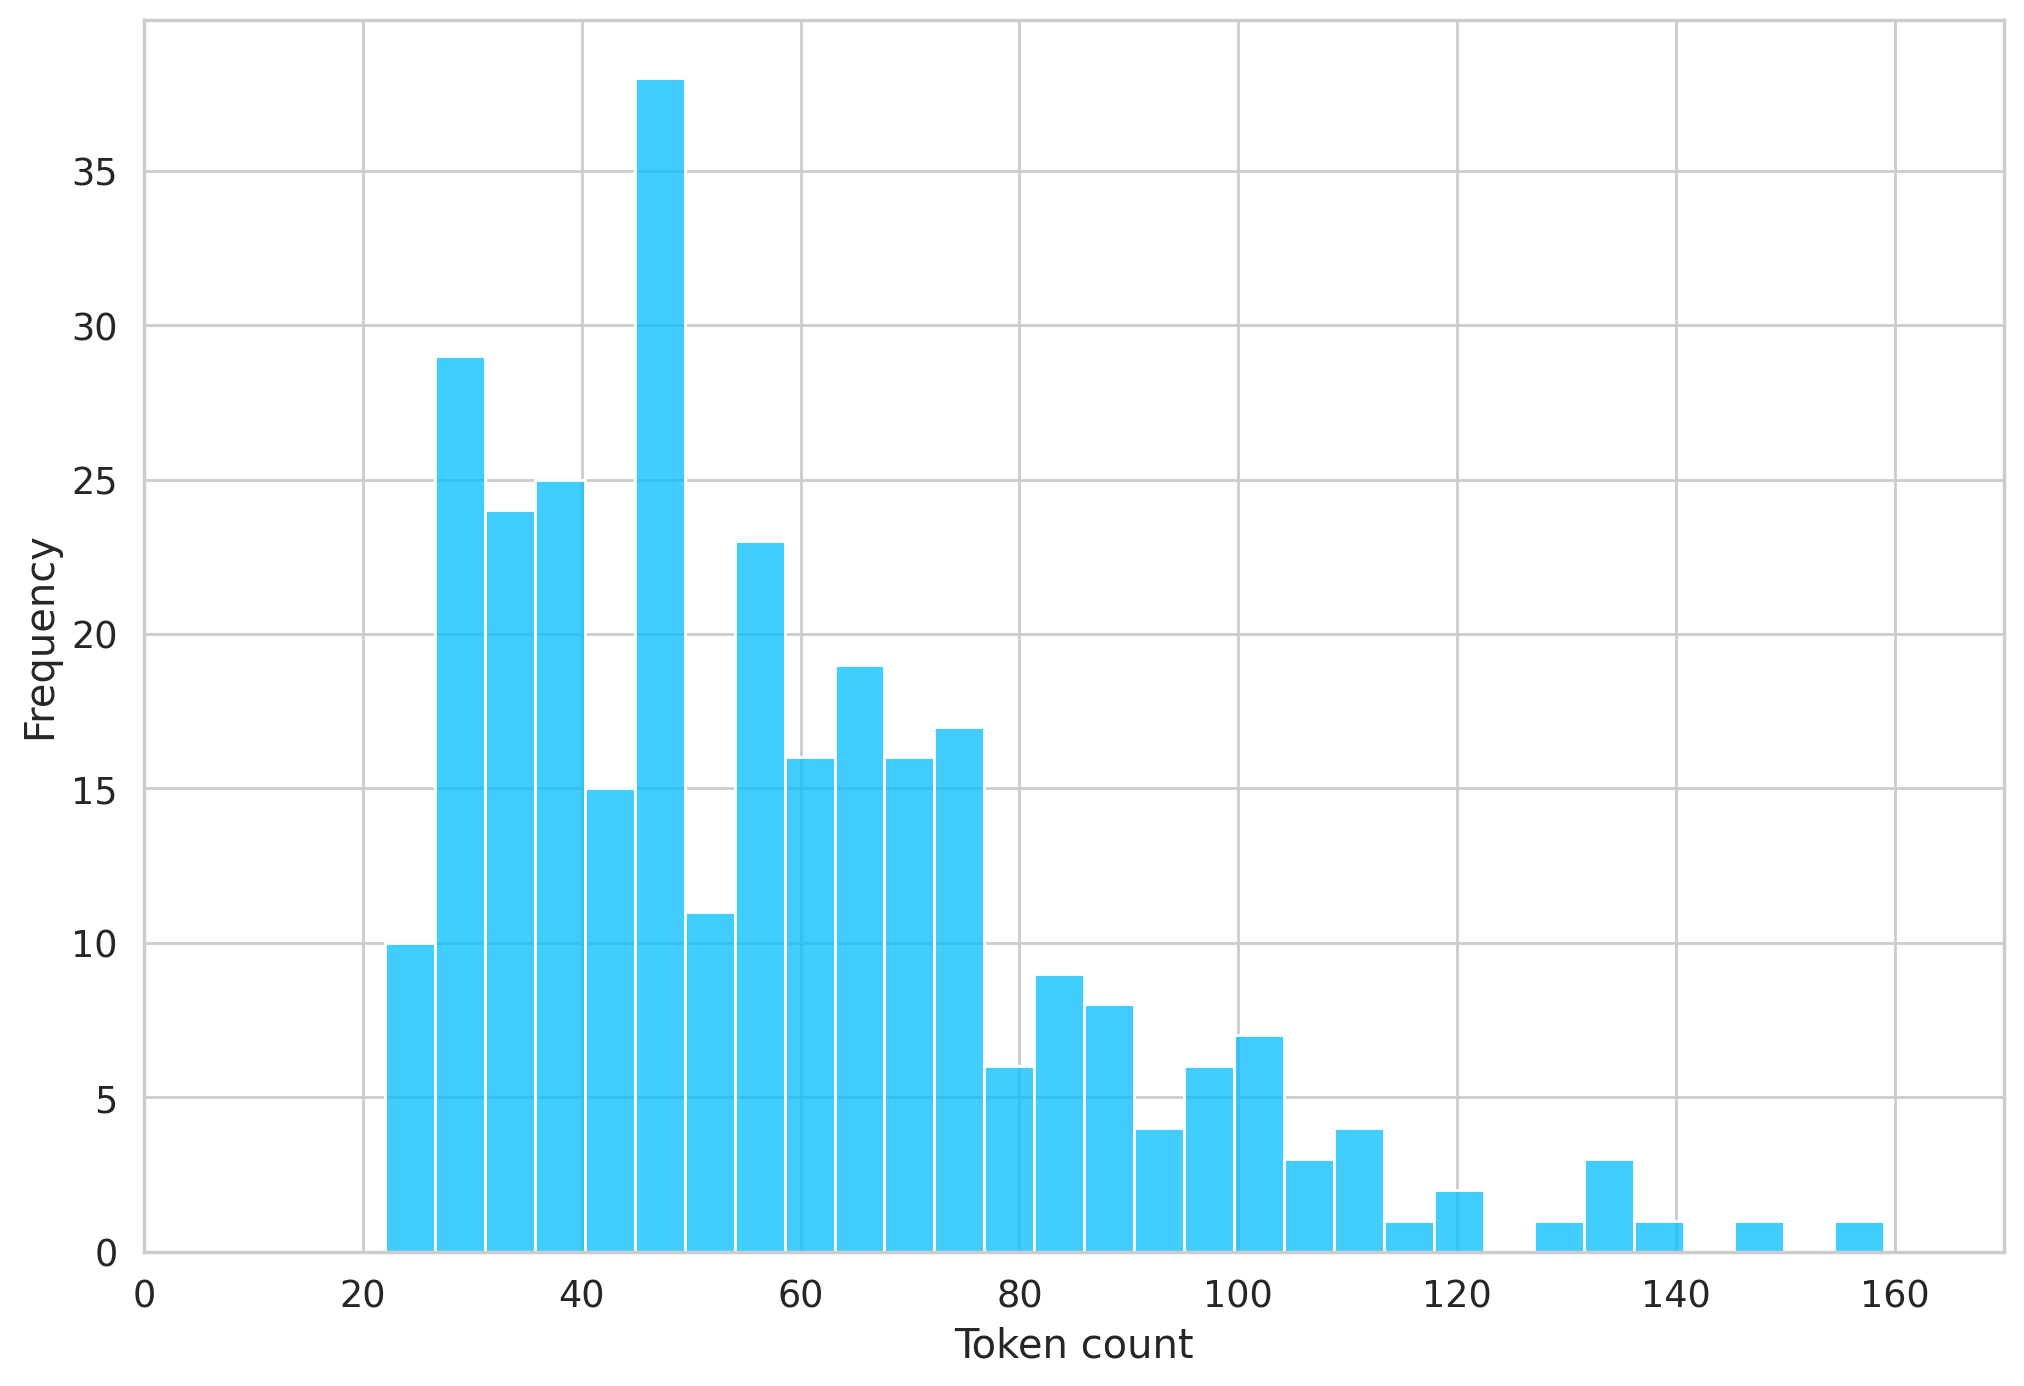

In [ ]:
from transformers import BertTokenizer
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Cargar el tokenizador
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Asegúrate de que df4 no tenga valores NaN en la columna 'tweet_text'
df4['tweet_text'] = df4['tweet_text'].fillna('')

# Lista para almacenar la longitud en tokens
token_lens = []

# Tokenizar cada texto y calcular la longitud en tokens
for txt in df4['tweet_text']:
    # Tokenizar sin truncación ni padding
    encoded = tokenizer.encode(
        txt,
        truncation=False,  # No truncar
        padding=False,  # No padding
        return_tensors=None  # No retornar tensores
    )
    # Añadir la longitud del texto tokenizado a la lista
    token_lens.append(len(encoded))  # Calcular la longitud de los tokens

# Calcular el promedio de longitudes de tokens
average_length = sum(token_lens) / len(token_lens)

# Calcular el Maximo de longitudes de tokens
MAX_LEN = max(token_lens)

# Mostrar el promedio y el maximo de longitud de tokens
print(f"Promedio de longitud de tokens: {average_length:.2f}")
print(f"Máximo de longitud de tokens: {MAX_LEN:.2f}")

# Generar el gráfico
sns.histplot(token_lens, kde=False, bins=30)  # Ajusta el número de bins si es necesario
plt.xlabel('Token count')
plt.ylabel('Frequency')
plt.xlim([0, 170])  # Ajusta los límites del eje x si es necesario
plt.show()

 Utilizamos GPReviewDataset para crear un dataset personalizado en PyTorch para la tarea de procesamiento de lenguaje natural (NLP). Se busca configurar el dataset con reseñas de texto, etiquetas asociadas, un tokenizador y la longitud máxima de tokens.

In [ ]:
from torch.utils.data import Dataset
import torch

class GPReviewDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets  # Asegúrate de que 'targets' es la columna 'sentiment_num'
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]

        # Asegúrate de que 'target' es numérico
        if isinstance(target, str):
            raise ValueError("Target must be numeric. Convert your sentiment labels to numeric values before using the dataset.")

        # Tokenización con truncation y padding explícito
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',  # Cambiado a 'padding' para evitar advertencias
            truncation=True,  # Activar truncation explícitamente
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)  # Asegúrate de que 'target' es numérico
        }


In [ ]:
df_train, df_test = train_test_split(df4, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((270, 7), (15, 7), (15, 7))

Definimos el data loader para cargar datos en batches para entrenamiento o evaluación de modelos.

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.tweet_text.to_numpy(),
        targets=df.sentiment_num.to_numpy(),  # Usar la variable numerica aquí
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
    )


In [ ]:
BATCH_SIZE = 2 # utilizamos 2 por las limitaciones de la CPU :(

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
data = next(iter(train_data_loader))
data.keys()
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([2, 159])
torch.Size([2, 159])
torch.Size([2])


# Sentiment Classification with BERT and Hugging Face

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

El método forward mueve los tensores *input_ids* y *attention_mask *al dispositivo adecuado y verifica sus dimensiones. Luego, crea un tensor de ceros para *token_type_ids* y pasa los datos a través del modelo BERT. La salida agrupada de BERT se somete a una capa de Dropout para regularización. Finalmente, se realiza la clasificación final con una capa de salida y se devuelve el resultado, incluyendo impresiones para depuración.

In [ ]:
def forward(self, input_ids, attention_mask):
    # Asegúrate de que input_ids y attention_mask estén en el dispositivo correcto
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)

    # Verifica las dimensiones y tipos de los tensores de entrada
    print(f"Input IDs shape: {input_ids.shape}, dtype: {input_ids.dtype}")
    print(f"Attention mask shape: {attention_mask.shape}, dtype: {attention_mask.dtype}")

    # Crea token_type_ids como un tensor de ceros con la forma adecuada
    token_type_ids = torch.zeros_like(input_ids)
    print(f"Token type IDs shape: {token_type_ids.shape}, dtype: {token_type_ids.dtype}")

    # Realiza la pasada hacia adelante con el modelo BERT
    outputs = self.bert(
        input_ids=input_ids,
        attention_mask=attention_mask,
        token_type_ids=token_type_ids
    )

    # Verifica la salida de BERT
    print(f"Outputs: {outputs}")
    print(f"Outputs type: {type(outputs)}")

    # Desempaca la salida de BERT
    pooled_output = outputs[1]  # Salida agrupada (pooled output)
    print(f"Pooled output shape: {pooled_output.shape}, dtype: {pooled_output.dtype}")

    # Aplica Dropout
    output = self.drop(pooled_output)
    print(f"Output shape: {output.shape}, dtype: {output.dtype}")

    # Realiza la clasificación final
    return self.out(output)


 Definimos la clase SentimentClassifier, que utiliza BERT como modelo base, aplica Dropout para regularización y realiza la clasificación final con una capa lineal. Finalmente, instanciamos el modelo, lo configuramos con el número de clases y lo movemos al dispositivo para el entrenamiento.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertModel, BertTokenizer

PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
class_names = ['negative', 'neutral', 'positive']
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = outputs.pooler_output
        output = self.drop(pooled_output)
        return self.out(output)

model = SentimentClassifier(len(class_names))
model = model.to(device)

In [ ]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [ ]:
print(input_ids.shape)  # Debe mostrar: torch.Size([16, 160])
print(attention_mask.shape)  # Debe mostrar: torch.Size([16, 160])

torch.Size([16, 160])
torch.Size([16, 160])


In [ ]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.3825, 0.3552, 0.2623],
        [0.3578, 0.3665, 0.2758],
        [0.4896, 0.3179, 0.1925],
        [0.2878, 0.4602, 0.2520],
        [0.3923, 0.3727, 0.2350],
        [0.3891, 0.3569, 0.2539],
        [0.4066, 0.4457, 0.1477],
        [0.4002, 0.3274, 0.2724],
        [0.3744, 0.4604, 0.1652],
        [0.4813, 0.3486, 0.1702],
        [0.4640, 0.2782, 0.2579],
        [0.3754, 0.3481, 0.2765],
        [0.4042, 0.3973, 0.1985],
        [0.3939, 0.2868, 0.3193],
        [0.3667, 0.4143, 0.2190],
        [0.4109, 0.3851, 0.2040]], grad_fn=<SoftmaxBackward0>)

## Entrenamiento

In [ ]:
!pip install transformers
import transformers
from transformers import AdamW

EPOCHS = 2

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

Definimos la función eval_model, que evalúa un modelo de clasificación en un conjunto de datos. La función pone el modelo en modo de evaluación y desactiva el cálculo de gradientes para evitar cálculos innecesarios. Luego, itera sobre el data_loader, moviendo los tensores al dispositivo adecuado y realizando inferencias con el modelo. Calcula la pérdida utilizando la función de pérdida proporcionada y cuenta el número de predicciones correctas. Finalmente, devuelve la precisión del modelo y la pérdida promedio en el conjunto de datos.

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

Se ejecuta un bucle de entrenamiento y evaluación del modelo para un número definido de épocas. En cada época, se entrena el modelo en el conjunto de entrenamiento y se evalúa en el conjunto de validación. Se imprime la pérdida y precisión de entrenamiento y validación, y se almacena esta información en un historial para su posterior análisis. Si la precisión en el conjunto de validación supera la mejor precisión registrada, se guarda el estado del modelo como el mejor modelo.

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/2
----------
Train loss 1.1736292132624873 accuracy 0.362962962962963
Val   loss 1.1150873303413391 accuracy 0.2

Epoch 2/2
----------
Train loss 1.1394513231736643 accuracy 0.35555555555555557
Val   loss 1.1001754403114319 accuracy 0.3333333333333333

CPU times: user 17min 47s, sys: 54.1 s, total: 18min 41s
Wall time: 19min 26s


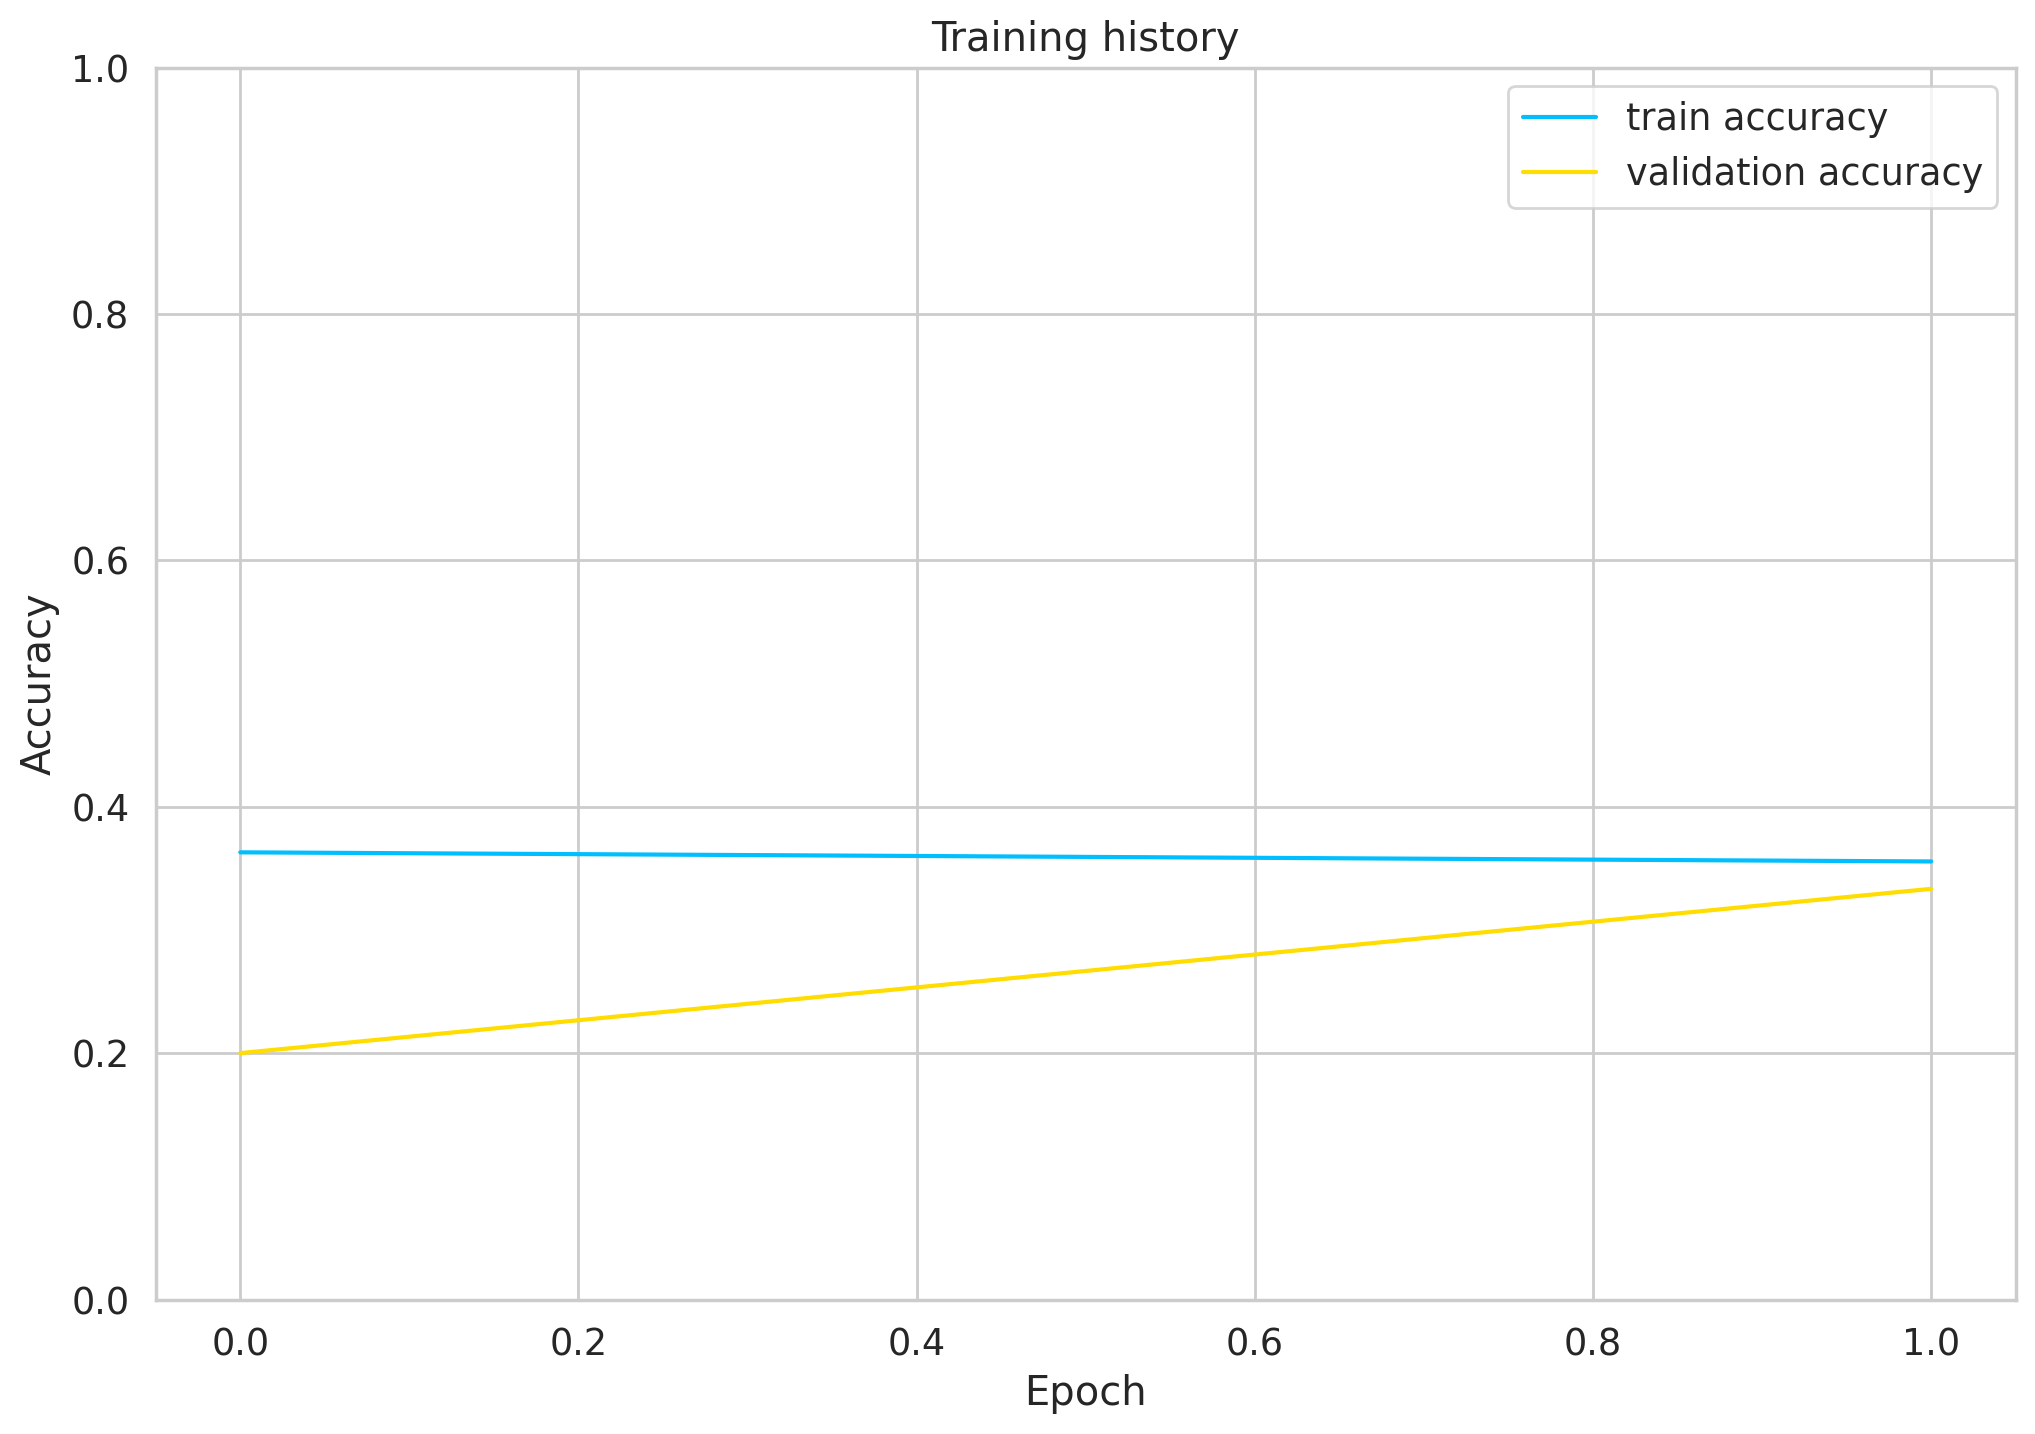

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

## Evaluación

A continuación, evaluamos el modelo en el conjunto de prueba utilizando la función eval_model. Se calcula la precisión (test_acc) en el conjunto de prueba y se extrae el valor numérico con .item(), que proporciona la precisión final del modelo en los datos de prueba.

Se obtiene una precisión del 60% en el conjunto de prueba, lo cual se atribuye a la baja cantidad de batch y épocas utilizadas durante el entrenamiento. Al usar tamaños de batch pequeños y un número reducido de épocas, el modelo puede no haber tenido suficiente tiempo y recursos para aprender patrones complejos en los datos. Aumentar el tamaño del batch y el número de épocas podría mejorar el rendimiento del modelo al permitir un entrenamiento más completo y efectivo.

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.6

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)


In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         3
     neutral       0.00      0.00      0.00         3
    positive       0.60      1.00      0.75         9

    accuracy                           0.60        15
   macro avg       0.20      0.33      0.25        15
weighted avg       0.36      0.60      0.45        15



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


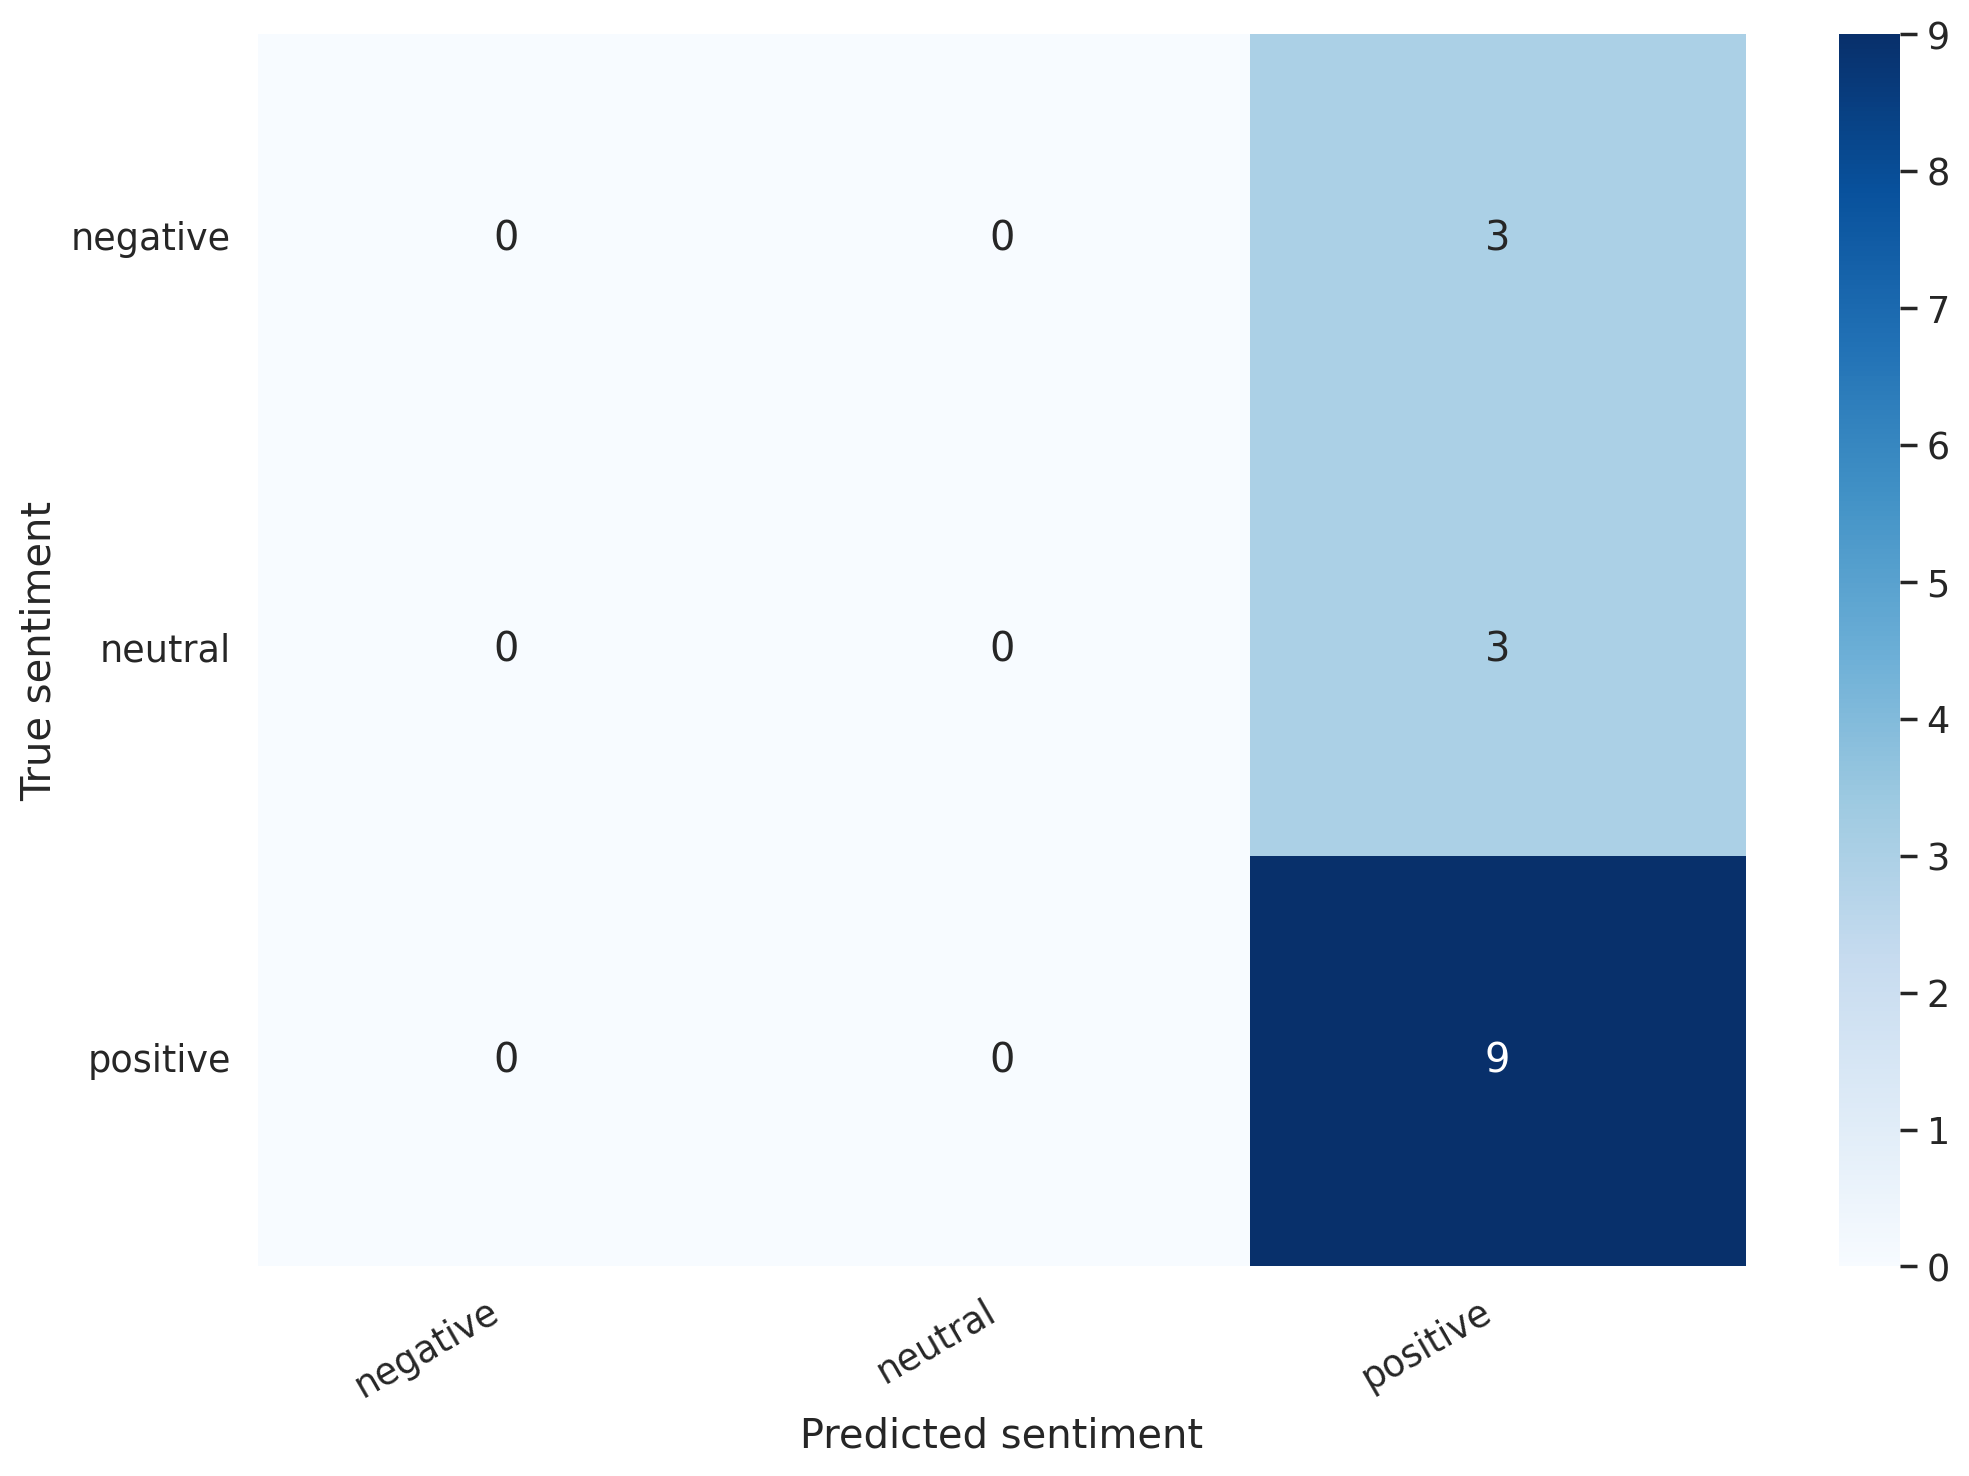

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
idx = 2

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [ ]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

Gracias Dios, no va a jugar el cono de Di María, ojalá pueda entrar
Pavon y Lo Celso en el 2T.   #VamosArgentina

True sentiment: positive


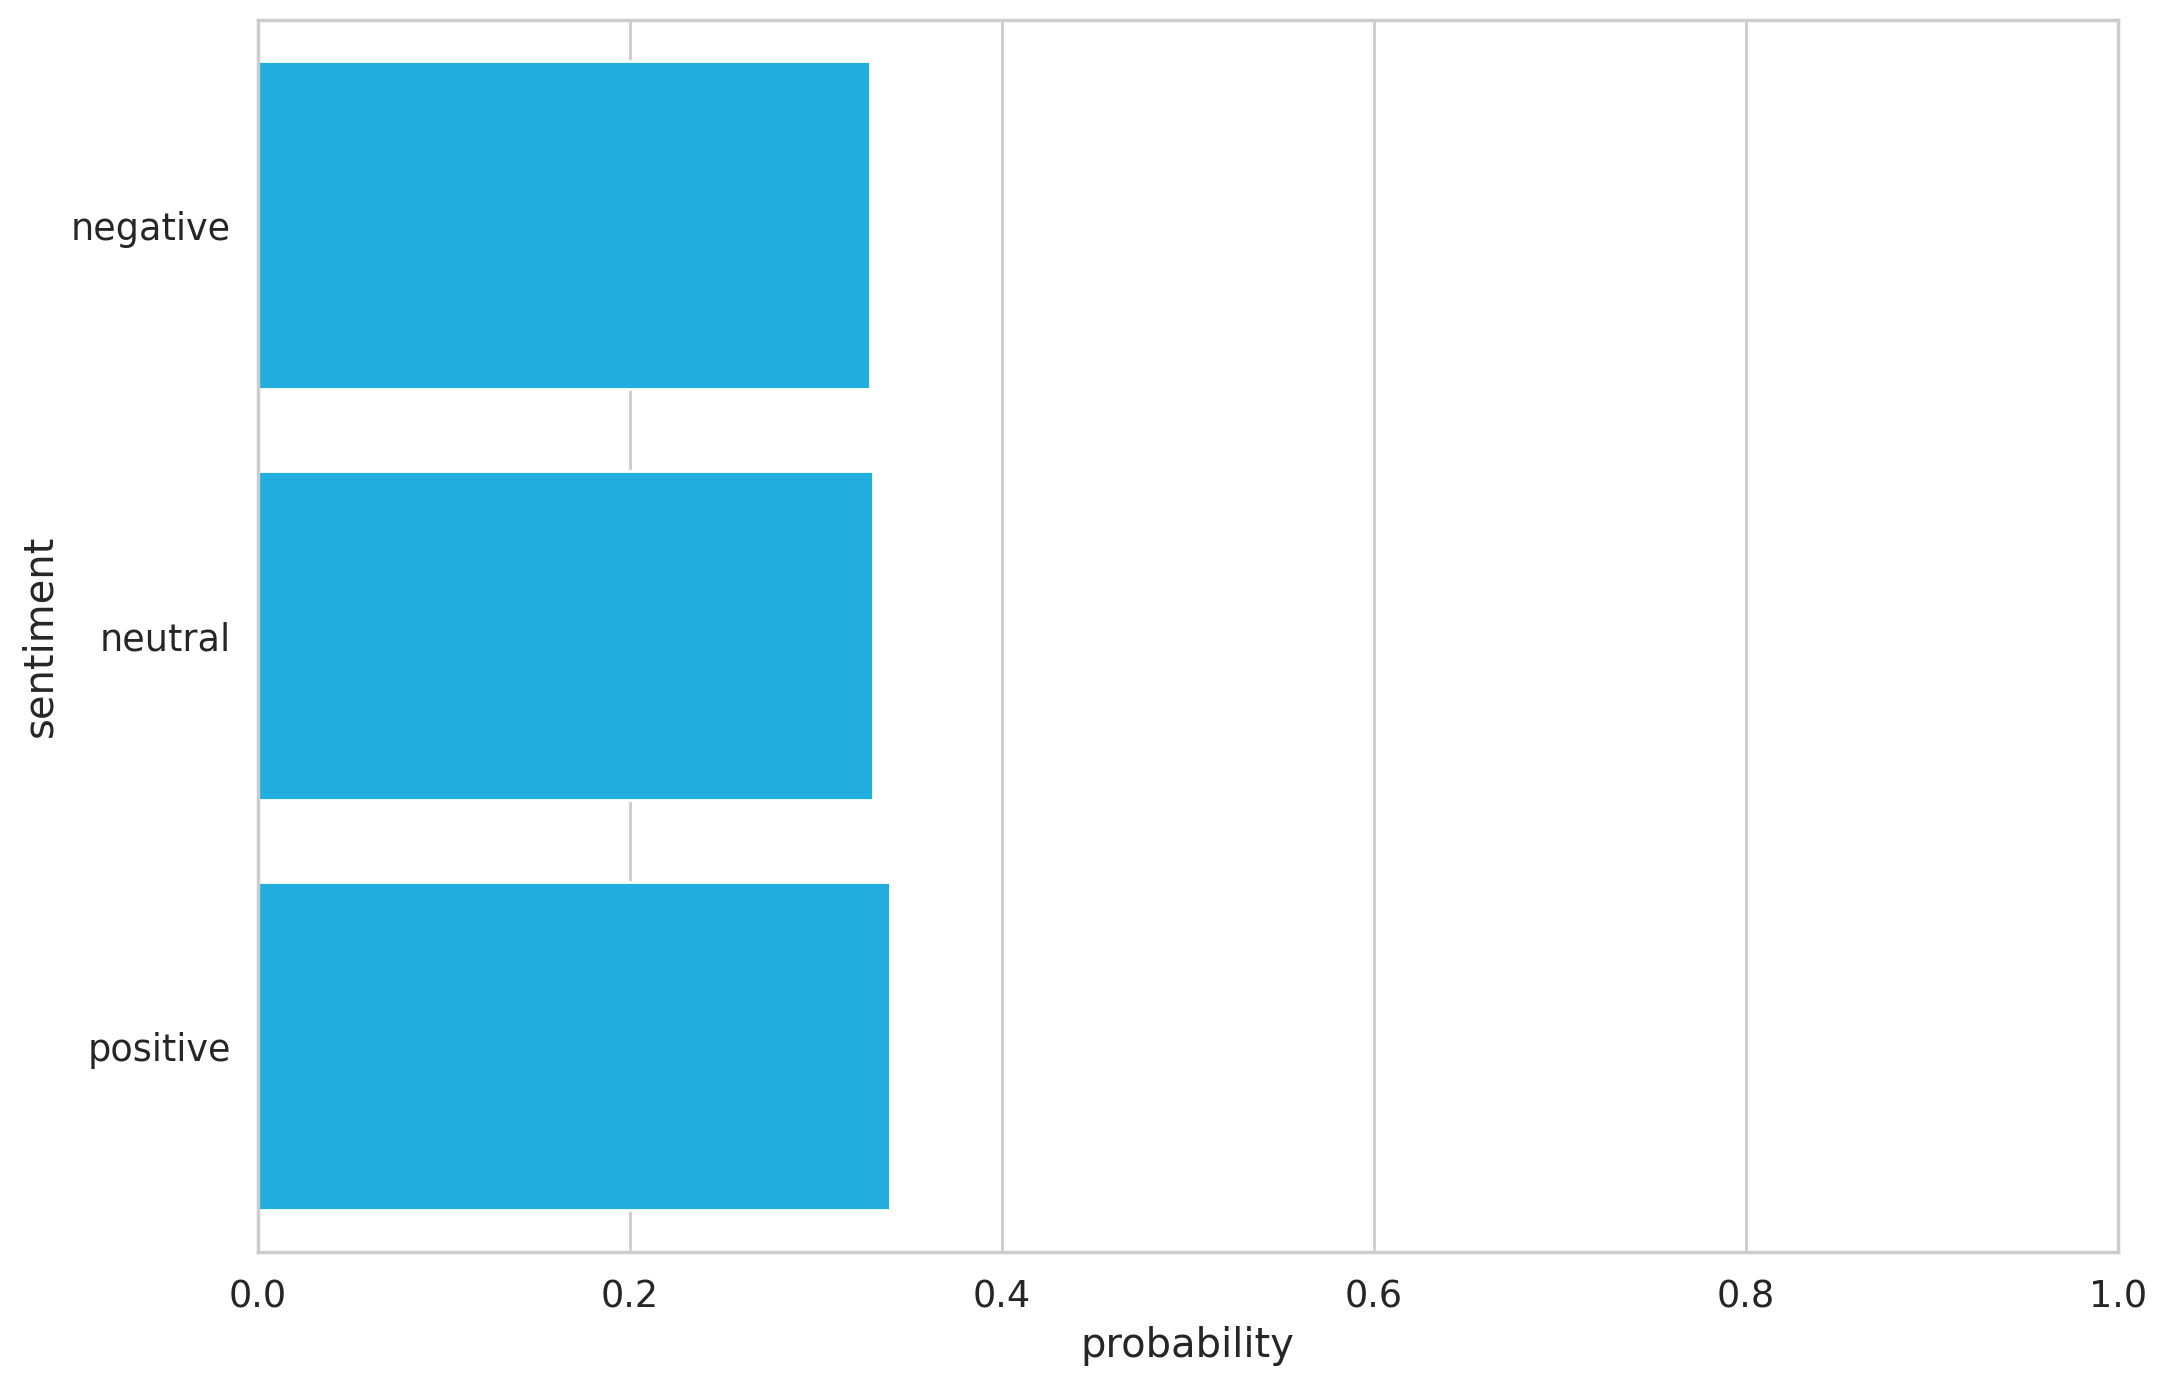

In [ ]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

In [ ]:
review_text = "el arbitro está comprado"

In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: el arbitro está comprado
Sentiment  : positive


# Referencias

- https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/blob/main/clase_7/jupyter_notebooks/pytorch/7d_bert_sentiment_analysis_multicategorial.ipynb

- https://github.com/charlesmalafosse/open-dataset-for-sentiment-analysis

In [ ]:
#@title Watch the video tutorial
#from IPython.display import YouTubeVideo
#YouTubeVideo('8N-nM3QW7O0', width=720, height=420)